In [2]:
from __future__ import print_function, division
import numpy as np
import scipy as sp
import neurofit as nf
import pyspike as pyspk
from scipy.signal import resample

import sys
sys.path.append("../") # for importing utils and glm

import utils
import glm

from os import walk


#plotting packages
%matplotlib inline
from matplotlib.pyplot import * # plotting functions
import seaborn as sns           # data visualization package
sns.set_style("whitegrid")

/home/tyler/.virtualenvs/dstrf/local/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [4]:
# load data from crcns
cell = "yg0616_4_B"
stim_type = "conspecific"

nspec = 15
t_dsample = 5
tlen = int(np.rint(150/t_dsample))
psth_smooth = t_dsample
plen = int(np.rint(50/t_dsample))

compress = 1
ncos = 8
spcos = 5
dt = 0.001

# load data from crcns
stims,durations = utils.load_crcns(cell,stim_type,nspec,t_dsample,compress)[:2]
dsdur = np.asarray(durations)/t_dsample

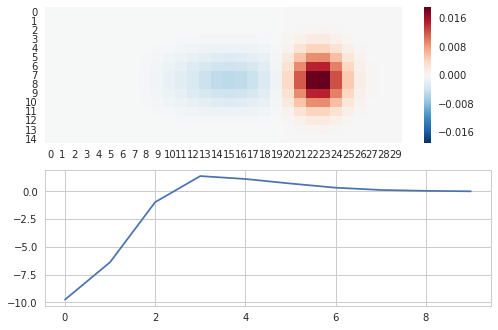

In [8]:
# build filters
normpdf = sp.stats.norm.pdf
dtsp = 0.001

nkt = tlen
nkx = nspec
nh = plen

kt = normpdf(range(nkt),3*nkt/4,1.5)-.5*normpdf(range(nkt),nkt/2,3)
kx = normpdf(range(nkx),nkx/2,2)
k = np.outer(kx,kt)
k = k/np.linalg.norm(k)/15

spec,tim = utils.factorize(k)
tbas, fromt, tot = utils.cosbasis(nkt,10,100,retfn=True)
costim = tot(tim)

hparam  = [-10,0.5,1,0.25,0]
hbas, fromh, toh = utils.cosbasis(nh,5,lin=10,retfn=True)
h = fromh(hparam)

subplot(211)
sns.heatmap(k)
subplot(212)
plot(h)

In [13]:
# generate some data
ntrials = 10

true_params = np.hstack(([0.5],spec[0],costim[0],hparam))

M = glm.GLM_cos(1,nkx,nkt,nh,10,5,100,spike=True,dt=dt)
M.set(true_params)

spikes_data = []
binary_data = []
model_data   = []

spiky_data = []

for s,dur in zip(stims,durations):
    dur = np.shape(s)[1]
    sr = []
    sspk = []
    s0 = []
    all_psth = []
    spiky = []
    
    for n in range(ntrials):
        z = np.zeros(dur,dtype=int)
        r,spikes = M.run(s)
        z[spikes] = 1
        sr.append(r)
        sspk.append(spikes)
        s0.append(z)
        spiky.append(pyspk.SpikeTrain(spikes,[0,dur]))

    model_data.append(sr)
    spikes_data.append(sspk)
    binary_data.append(s0)
    spiky_data.append(spiky)

all_psth = [utils.psth(spk,np.shape(st)[1],1) for spk,st in zip(spikes_data,stims)]
fit_psth = [np.log(p*1000 + 1) for p in all_psth]
eocorr = [utils.evenoddcorr(spks,dur,dsample=t_dsample,smooth=psth_smooth) for spks,dur in zip(spikes_data,durations)]
print("EO: {:.2f}".format(np.mean(eocorr)))

EO: 0.92


In [14]:
STRF_GUESS, B_GUESS = utils.get_strf(stims,fit_psth,nkt)
SPEC,TIM = utils.factorize(STRF_GUESS,1)
start = np.hstack(([[B_GUESS]],SPEC,tot(TIM),[[0]*5])).flatten()

In [15]:
XXstim = [utils.design_matrix([np.pad(s,((0,0),(tlen-1,0)),"edge")],[p],tlen)[0] for s,p in zip(stims,all_psth)]
XXspk =  [[utils.ps_design([np.pad(s,(tlen-1,0),"edge")],[all_psth[0]],plen,tlen)[0] for s in ss ] for ss in binary_data]

np.shape(XXstim[0]),np.shape(XXspk[0])

#LM = lm.ElasticNetCV(normalize=True)
#LM.fit(XX,R)


((358, 450), (10, 358, 10))

In [223]:
class cosstrf_design():
    def __init__(self, channels, nspec, tlen, ncos=10,coslin=1):
        self.channels = channels
        self.nspec = nspec
        self.tlen = tlen
        self.ncos = ncos
        self.cosbas = utils.cosbasis(tlen,ncos,lin=coslin)
        self.invbas = np.linalg.pinv(self.cosbas)
        self.tfilt = None
        self.sfilt = None
        self.filt = None
        
    def set(self,theta):
        flat_sfilt = theta[:self.nspec*self.channels]
        flat_tfilt = theta[self.nspec*self.channels:]
        self.sfilt = np.reshape(flat_sfilt,(self.channels,self.nspec))
        self.tfilt = np.matmul(self.cosbas,np.reshape(flat_tfilt,(self.channels,self.ncos)).T).T
        self.filt  = np.fliplr(np.matmul(self.sfilt.T,self.tfilt)).flatten()
        
    def run(self,stim):
        return np.dot(stim,self.filt)

In [495]:
class GLM_design():
    def __init__(self,channels,nspec,tlen,hlen,tcos=10,hcos=8,tcoslin=1,hcoslin=10,nonlin=np.exp,spike=False,dt=0.001):
        self.nonlin = nonlin if nonlin is not None else lambda x: x
        self.k = cosstrf_design(channels,nspec,tlen,tcos,tcoslin)
        self.h = cosstrf_design(1,1,hlen,hcos,hcoslin)
        self.post_spike = None
        self.offset = 0
        self.spike=spike
        self.nh = hlen
        self.dt=dt
        self.tlen = tlen
        self.hlen=hlen

    def set(self,theta):
        self.offset,ktheta,htheta = np.split(theta,[1,-self.h.ncos])
        self.k.set(ktheta)
        self.h.set(np.hstack((1,htheta)))
        
    def run(self,data):
        stim, observed_spikes = data if np.shape(data) == (2,) else (data,None)
        
        synap = self.k.run(stim)
        
        duration = synap.size
        
        spikes = np.zeros(duration+1) 
        spike_times = []    
        
        
        if observed_spikes is not None:
            rate = []
            
            for ob in observed_spikes:   
                spike_times.append(np.where(ob[:,-1] > 0)[0]-1)
                post = self.h.run([ob])
                rate.append(self.nonlin(synap + post + self.offset)[0]*self.dt)
                
        else:
            spikes = np.zeros(duration+1) 
            rate = np.zeros(duration)
            
            make_design = lambda spks: utils.ps_design([np.pad(spks,(self.tlen-1,0),"edge")],[spks],self.hlen,self.tlen)[0]
            design = make_design(spikes)
            
            for i in range(duration):
                x = design[i]
                post = self.h.run(x)
                r = synap[i] + post + self.offset
                rate[i] = self.nonlin(r)*self.dt

                if np.random.poisson(rate[i]) > 0:
                    spikes[i] = 1
                    spike_times.append(i)
                    design = make_design(spikes)
                    
                    
        return (rate, spike_times) if self.spike else rate


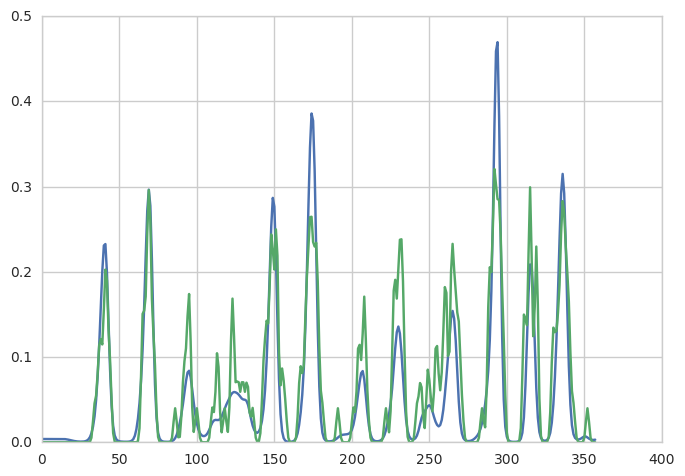

In [496]:
model = GLM_design(1,nkx,nkt,nh,hcos=5,tcoslin=100,nonlin=np.exp,spike=True,dt=dt)
model.set(start)
plot(model.run([XXstim[0],[XXspk[0][0]]])[0][0].T)
plot(all_psth[0])

In [429]:
def loss(predict,data):
    #print(np.sum(1000*((predict - data))**2)/len(predict))
    return np.sum(1000*((predict - data))**2)/len(predict)

def loss2(predict,data):
    #print(-np.sum(ss.norm.logpdf(predict,loc=data)))
    return -np.sum(ss.norm.logpdf(predict,loc=data))

def pploss(predict,data):
    lam,spikes = predict
    if np.shape(lam[0]) == ():
        lam = [lam]
        spikes = [spikes]
    return -np.sum([np.sum(np.log(l[s])) - np.sum(l) for s,l in zip(spikes,lam)])

def pploss2(predict,data):
    lam,spikes = predict
    mask = np.zeros(len(lam),bool)
    mask[spikes] = True
    sterm = np.sum(np.log(lam[mask])) if len(spikes) > 0 else 0
    nterm = np.sum(np.log(1-lam[~mask])) 
    #print(sterm+nterm,sterm,nterm,lam[~mask])
    return -sterm + nterm 

def cost(theta, model, lnprior, lnlike, observs,fixed):

    lp = lnprior(theta)
    if not np.isfinite(lp): return -np.inf
    params = np.hstack((fixed,theta))
    
    model.set(params)
    
    ll = 0
    for stim, data, in observs:
        ll += lnlike(model.run(stim), data)
        if np.isnan(ll): return -np.inf
        
    return -ll + lp
                 
prior = nf.priors.unbounded()

In [430]:
model = GLM_design(1,nkx,nkt,nh,hcos=5,tcoslin=100,nonlin=np.exp,spike=True,dt=dt)

data = zip(zip(XXstim,XXspk),all_psth)

ncost = lambda *args: -cost(*args)

from scipy import optimize as opt

fixed = start[:-5]
%time result = opt.minimize(ncost,start[-5:],args=(model,prior,pploss,data,fixed))

CPU times: user 2.54 s, sys: 0 ns, total: 2.54 s
Wall time: 2.62 s


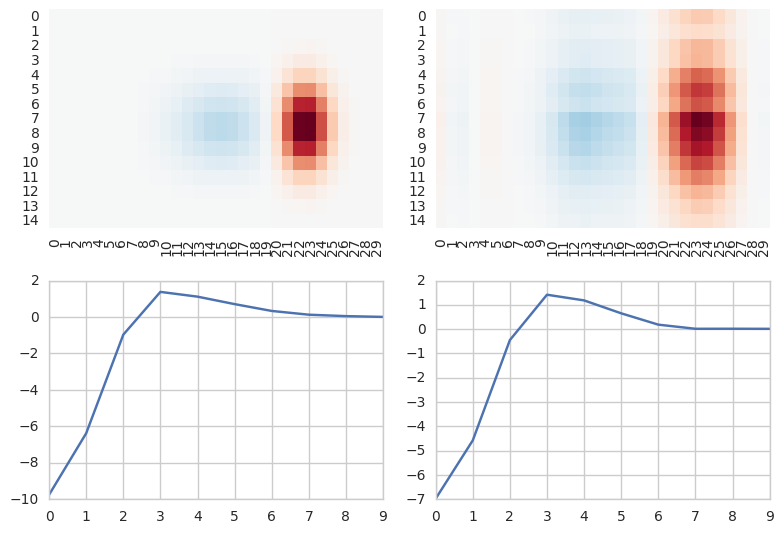

In [434]:
emcee_start = np.hstack((fixed,result['x']))
model.set(emcee_start)

subplot(221)
sns.heatmap(k,cbar=False)

subplot(222)
sns.heatmap(np.fliplr(model.k.filt.reshape(15,30)),cbar=False)

subplot(223)
plot(h)

subplot(224)
plot(model.h.filt.T[::-1])

tight_layout()

In [435]:
import emcee

nwalkers = 1000
pos0 = emcee.utils.sample_ball(start,[0.1]*len(start),nwalkers)

out = nf.fit(all_psth,zip(XXstim,XXspk),model,prior,pploss,nwalkers,1000,1,pos0,progress_bar=True,threads=8)

/scratch/tyler/dstrf/.pip/ipykernel/__main__.py:34: RuntimeWarning: overflow encountered in exp
/scratch/tyler/dstrf/.pip/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in double_scalars
/scratch/tyler/dstrf/.pip/ipykernel/__main__.py:34: RuntimeWarning: overflow encountered in exp
/scratch/tyler/dstrf/.pip/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in double_scalars


 [          ] 1/1000 samples in 00:20 about 38:45 remaining

/scratch/tyler/dstrf/.pip/ipykernel/__main__.py:34: RuntimeWarning: overflow encountered in exp
/scratch/tyler/dstrf/.pip/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in double_scalars
/scratch/tyler/dstrf/.pip/ipykernel/__main__.py:34: RuntimeWarning: overflow encountered in exp
/scratch/tyler/dstrf/.pip/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in double_scalars


 [          ] 2/1000 samples in 00:29 about 28:38 remaining

/scratch/tyler/dstrf/.pip/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in log


 [          ] 3/1000 samples in 00:37 about 19:12 remaining

/scratch/tyler/dstrf/.pip/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in log
/scratch/tyler/dstrf/.pip/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in log
/scratch/tyler/dstrf/.pip/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in log


 [          ] 4/1000 samples in 00:46 about 26:46 remaining

/scratch/tyler/dstrf/.pip/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in log


 [          ] 5/1000 samples in 00:55 about 22:17 remaining

/scratch/tyler/dstrf/.pip/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in log
/scratch/tyler/dstrf/.pip/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in log


 [          ] 9/1000 samples in 01:29 about 25:43 remaining

/scratch/tyler/dstrf/.pip/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in log


 [##########] 1000 samples in 59:34

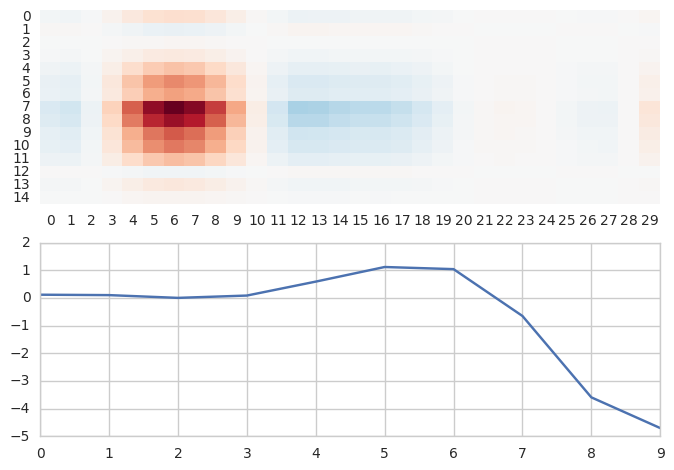

In [497]:
model.set(out.flatchain[np.argmax(out.flatlnprobability)])
subplot(211)
sns.heatmap(model.k.filt.reshape(nspec,tlen),cbar=False)

subplot(212)
plot(model.h.filt.T)

In [512]:
all_corr = []
for stim,spks,spsth in zip(XXstim,XXspk,all_psth):
    trace = []
    for i in range(10):
        trace.append(model.run(stim)[0])
        corr = np.corrcoef(np.mean(trace,axis=0),spsth)
    all_corr.append(corr)
        
print(np.mean(all_corr))

0.911349400195
